# **Model hyperparameters optimization**

In [38]:
import os
import sys
sys.path.append('/Users/damienmellot/desktop/MLE/Projects/fml/stock-price-prediction/')

import warnings
warnings.filterwarnings('ignore')

import src.settings.base as stg
from src.infrastructure.datasetcreation import DataFrameBuilder
from src.domain.datatransformation import DatasetTransformer

from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [23]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [25]:
from statsmodels.tsa.arima.model import ARIMA

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

In [26]:
dfb = DataFrameBuilder(stg.MSFT_R21_data)
df = dfb.data
X = dfb.features
Y = dfb.target

In [27]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [28]:
num_folds = 10
scoring = 'neg_mean_squared_error'

In [29]:
models = []

models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [30]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    msg = f"{name}: {round(cv_results.mean(), 5)} ({round(cv_results.std(), 5)})"
    print(msg)

LR: 0.00044 (0.00012)
LASSO: 0.00297 (0.00144)
EN: 0.00297 (0.00144)
KNN: 0.00095 (0.00034)
CART: 0.00097 (0.00023)
SVR: 0.00148 (0.00082)
MLP: 0.0007 (0.0003)
ABR: 0.00058 (0.00014)
GBR: 0.00048 (0.00012)
RFR: 0.0005 (0.00013)
ETR: 0.0005 (0.00014)


# GridSearch

## 1. LinearRegression

In [9]:
'''
fit_intercept : boolean, optional, default True
    whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (e.g. data is expected to be already centered).
'''
param_grid = {'fit_intercept': [True, False]}
model = LinearRegression()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00044 using {'fit_intercept': True}
Mean: -0.00044, Stdev: 0.00012 with: {'fit_intercept': True}
Mean: -0.00044, Stdev: 0.00012 with: {'fit_intercept': False}


## 2. Lasso

In [10]:
'''
alpha : float, optional
    Constant that multiplies the L1 term. Defaults to 1.0.
    ``alpha = 0`` is equivalent to an ordinary least square, solved
    by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.
''' 
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1, 1.5, 3, 5]}
model = Lasso()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00297 using {'alpha': 0.01}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.01}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.1}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.3}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.7}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 1}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 1.5}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 3}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 5}


## 3. ElasticNet

In [12]:
'''
alpha : float, optional
    Constant that multiplies the penalty terms. Defaults to 1.0.
    See the notes for the exact mathematical meaning of this
    parameter.``alpha = 0`` is equivalent to an ordinary least square,
    solved by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.

l1_ratio : float
    The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For
    ``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` it
    is an L1 penalty.  For ``0 < l1_ratio < 1``, the penalty is a
    combination of L1 and L2.
'''
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1, 1.5, 3, 5],
              'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]}
model = ElasticNet()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")


means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00109 using {'alpha': 0.01, 'l1_ratio': 0.01}
Mean: -0.00109, Stdev: 0.00052 with: {'alpha': 0.01, 'l1_ratio': 0.01}
Mean: -0.00153, Stdev: 0.00077 with: {'alpha': 0.01, 'l1_ratio': 0.1}
Mean: -0.00294, Stdev: 0.00146 with: {'alpha': 0.01, 'l1_ratio': 0.3}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.01, 'l1_ratio': 0.5}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.01, 'l1_ratio': 0.7}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.01, 'l1_ratio': 0.9}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.01, 'l1_ratio': 0.99}
Mean: -0.00257, Stdev: 0.00127 with: {'alpha': 0.1, 'l1_ratio': 0.01}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.1, 'l1_ratio': 0.1}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.1, 'l1_ratio': 0.3}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.1, 'l1_ratio': 0.5}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.1, 'l1_ratio': 0.7}
Mean: -0.00297, Stdev: 0.00144 with: {'alpha': 0.1, 'l1_ratio': 0.9}
Mean: -0.00297, Stdev: 0.00144 with: {

## 4. KNeighborsRegressor 

In [13]:
'''
n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for :meth:`kneighbors` queries.
'''
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,19,21]}
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds
             )
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00088 using {'n_neighbors': 15}
Mean: -0.00153, Stdev: 0.00043 with: {'n_neighbors': 1}
Mean: -0.00105, Stdev: 0.00036 with: {'n_neighbors': 3}
Mean: -0.00095, Stdev: 0.00034 with: {'n_neighbors': 5}
Mean: -0.00091, Stdev: 0.00034 with: {'n_neighbors': 7}
Mean: -0.0009, Stdev: 0.00035 with: {'n_neighbors': 9}
Mean: -0.00089, Stdev: 0.00035 with: {'n_neighbors': 11}
Mean: -0.00089, Stdev: 0.00036 with: {'n_neighbors': 13}
Mean: -0.00088, Stdev: 0.00036 with: {'n_neighbors': 15}
Mean: -0.00089, Stdev: 0.00036 with: {'n_neighbors': 17}
Mean: -0.00089, Stdev: 0.00037 with: {'n_neighbors': 19}
Mean: -0.00089, Stdev: 0.00037 with: {'n_neighbors': 21}


## 5. DecisionTreeRegressor 



In [14]:
'''
min_samples_split : int, float, optional (default=2)
    The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a percentage and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.
'''
param_grid={'min_samples_split': [2,3,4,5,6,7,8,9,10]}
model = DecisionTreeRegressor()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00084 using {'min_samples_split': 10}
Mean: -0.00098, Stdev: 0.00022 with: {'min_samples_split': 2}
Mean: -0.00097, Stdev: 0.00023 with: {'min_samples_split': 3}
Mean: -0.00095, Stdev: 0.0002 with: {'min_samples_split': 4}
Mean: -0.00092, Stdev: 0.00019 with: {'min_samples_split': 5}
Mean: -0.0009, Stdev: 0.0002 with: {'min_samples_split': 6}
Mean: -0.0009, Stdev: 0.00018 with: {'min_samples_split': 7}
Mean: -0.00087, Stdev: 0.00017 with: {'min_samples_split': 8}
Mean: -0.00087, Stdev: 0.00015 with: {'min_samples_split': 9}
Mean: -0.00084, Stdev: 0.00015 with: {'min_samples_split': 10}


## 6. SVR 



In [15]:
'''
C : float, optional (default=1.0)
    Penalty parameter C of the error term.

epsilon : float, optional (default=0.1)
     Epsilon in the epsilon-SVR model. It specifies the epsilon-tube
     within which no penalty is associated in the training loss function
     with points predicted within a distance epsilon from the actual
     value.
gamma : float, optional (default='auto')
    Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    If gamma is 'auto' then 1/n_features will be used instead.
'''
param_grid={'C': [0.01, 0.03,0.1,0.3,1,3,10,30,100],
            'gamma': [0.001, 0.01, 0.1, 1],
            'epsilon': [0.01, 0.1, 1]}
model = SVR()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00044 using {'C': 3, 'epsilon': 0.01, 'gamma': 0.1}
Mean: -0.00293, Stdev: 0.00142 with: {'C': 0.01, 'epsilon': 0.01, 'gamma': 0.001}
Mean: -0.00262, Stdev: 0.00127 with: {'C': 0.01, 'epsilon': 0.01, 'gamma': 0.01}
Mean: -0.0012, Stdev: 0.00057 with: {'C': 0.01, 'epsilon': 0.01, 'gamma': 0.1}
Mean: -0.00066, Stdev: 0.00025 with: {'C': 0.01, 'epsilon': 0.01, 'gamma': 1}
Mean: -0.00297, Stdev: 0.00148 with: {'C': 0.01, 'epsilon': 0.1, 'gamma': 0.001}
Mean: -0.0029, Stdev: 0.00146 with: {'C': 0.01, 'epsilon': 0.1, 'gamma': 0.01}
Mean: -0.00248, Stdev: 0.00127 with: {'C': 0.01, 'epsilon': 0.1, 'gamma': 0.1}
Mean: -0.00176, Stdev: 0.00091 with: {'C': 0.01, 'epsilon': 0.1, 'gamma': 1}
Mean: -0.00325, Stdev: 0.00154 with: {'C': 0.01, 'epsilon': 1, 'gamma': 0.001}
Mean: -0.00325, Stdev: 0.00154 with: {'C': 0.01, 'epsilon': 1, 'gamma': 0.01}
Mean: -0.00325, Stdev: 0.00154 with: {'C': 0.01, 'epsilon': 1, 'gamma': 0.1}
Mean: -0.00325, Stdev: 0.00154 with: {'C': 0.01, 'epsilon': 1, 'gamma

## 7. MLPRegressor

In [17]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00079 using {'hidden_layer_sizes': (50,)}
Mean: -0.00108, Stdev: 0.00045 with: {'hidden_layer_sizes': (20,)}
Mean: -0.00079, Stdev: 0.00028 with: {'hidden_layer_sizes': (50,)}
Mean: -0.00085, Stdev: 0.00033 with: {'hidden_layer_sizes': (20, 20)}
Mean: -0.00087, Stdev: 0.0003 with: {'hidden_layer_sizes': (20, 30, 20)}


## 8. RandomForestRegressor 

In [21]:
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00049 using {'n_estimators': 350}
Mean: -0.00051, Stdev: 0.00012 with: {'n_estimators': 50}
Mean: -0.0005, Stdev: 0.00013 with: {'n_estimators': 100}
Mean: -0.0005, Stdev: 0.00012 with: {'n_estimators': 150}
Mean: -0.00049, Stdev: 0.00012 with: {'n_estimators': 200}
Mean: -0.0005, Stdev: 0.00012 with: {'n_estimators': 250}
Mean: -0.0005, Stdev: 0.00012 with: {'n_estimators': 300}
Mean: -0.00049, Stdev: 0.00012 with: {'n_estimators': 350}
Mean: -0.0005, Stdev: 0.00012 with: {'n_estimators': 400}


## 9. GradientBoostingRegressor 



In [18]:
'''
n_estimators:

    The number of boosting stages to perform. Gradient boosting
    is fairly robust to over-fitting so a large number usually
    results in better performance.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = GradientBoostingRegressor()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00047 using {'n_estimators': 50}
Mean: -0.00047, Stdev: 0.00013 with: {'n_estimators': 50}
Mean: -0.00048, Stdev: 0.00012 with: {'n_estimators': 100}
Mean: -0.00049, Stdev: 0.00012 with: {'n_estimators': 150}
Mean: -0.0005, Stdev: 0.00012 with: {'n_estimators': 200}
Mean: -0.00051, Stdev: 0.00011 with: {'n_estimators': 250}
Mean: -0.00052, Stdev: 0.00011 with: {'n_estimators': 300}
Mean: -0.00052, Stdev: 0.00011 with: {'n_estimators': 350}
Mean: -0.00052, Stdev: 0.00011 with: {'n_estimators': 400}


## 10. ExtraTreesRegressor 



In [19]:
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = ExtraTreesRegressor()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00049 using {'n_estimators': 400}
Mean: -0.00051, Stdev: 0.00014 with: {'n_estimators': 50}
Mean: -0.0005, Stdev: 0.00014 with: {'n_estimators': 100}
Mean: -0.0005, Stdev: 0.00014 with: {'n_estimators': 150}
Mean: -0.0005, Stdev: 0.00014 with: {'n_estimators': 200}
Mean: -0.0005, Stdev: 0.00014 with: {'n_estimators': 250}
Mean: -0.0005, Stdev: 0.00014 with: {'n_estimators': 300}
Mean: -0.0005, Stdev: 0.00014 with: {'n_estimators': 350}
Mean: -0.00049, Stdev: 0.00014 with: {'n_estimators': 400}


## 11. AdaBoostRegression

In [20]:
'''
n_estimators : integer, optional (default=50)
    The maximum number of estimators at which boosting is terminated.
    In case of perfect fit, the learning procedure is stopped early.

learning_rate : float, optional (default=1.)
    Learning rate shrinks the contribution of each regressor by
    ``learning_rate``. There is a trade-off between ``learning_rate`` and
    ``n_estimators``.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400],
             'learning_rate': [1, 2, 3]}
model = AdaBoostRegressor()
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best: {round(grid_result.best_score_, 5)} using {grid_result.best_params_}")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {round(mean, 5)}, Stdev: {round(stdev, 5)} with: {param}")

Best: -0.00059 using {'learning_rate': 1, 'n_estimators': 50}
Mean: -0.00059, Stdev: 0.00016 with: {'learning_rate': 1, 'n_estimators': 50}
Mean: -0.00061, Stdev: 0.00015 with: {'learning_rate': 1, 'n_estimators': 100}
Mean: -0.00063, Stdev: 0.00015 with: {'learning_rate': 1, 'n_estimators': 150}
Mean: -0.00064, Stdev: 0.00016 with: {'learning_rate': 1, 'n_estimators': 200}
Mean: -0.00066, Stdev: 0.00016 with: {'learning_rate': 1, 'n_estimators': 250}
Mean: -0.00065, Stdev: 0.00015 with: {'learning_rate': 1, 'n_estimators': 300}
Mean: -0.00065, Stdev: 0.00015 with: {'learning_rate': 1, 'n_estimators': 350}
Mean: -0.00065, Stdev: 0.00015 with: {'learning_rate': 1, 'n_estimators': 400}
Mean: -0.00064, Stdev: 0.00015 with: {'learning_rate': 2, 'n_estimators': 50}
Mean: -0.00063, Stdev: 0.00017 with: {'learning_rate': 2, 'n_estimators': 100}
Mean: -0.00064, Stdev: 0.00015 with: {'learning_rate': 2, 'n_estimators': 150}
Mean: -0.00063, Stdev: 0.00015 with: {'learning_rate': 2, 'n_estimators

## 12. ARIMA Model

In [31]:
X_train_ARIMA = X_train.loc[:, [stg.MSFT_lagged, stg.GOOGL_lagged, stg.IBM_lagged, 
                                stg.DEXJPUS_lagged, stg.DEXUSUK_lagged, 
                                stg.SP500_lagged, stg.DJIA_lagged, stg.VIXCLS_lagged]]
X_test_ARIMA = X_test.loc[:, [stg.MSFT_lagged, stg.GOOGL_lagged, stg.IBM_lagged, 
                              stg.DEXJPUS_lagged, stg.DEXUSUK_lagged, 
                              stg.SP500_lagged, stg.DJIA_lagged, stg.VIXCLS_lagged]]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
model_fit = modelARIMA.fit()

In [7]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
         
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()   
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0004362
ARIMA(0, 0, 1) MSE=0.0004362
ARIMA(0, 1, 0) MSE=0.0004519
ARIMA(0, 1, 1) MSE=0.0004519
ARIMA(1, 0, 0) MSE=0.0004362
ARIMA(1, 0, 1) MSE=0.0004362
ARIMA(1, 1, 0) MSE=0.0004519
ARIMA(1, 1, 1) MSE=0.0004519
ARIMA(2, 0, 0) MSE=0.0004362
ARIMA(2, 0, 1) MSE=0.0004362
ARIMA(2, 1, 0) MSE=0.0004512
ARIMA(2, 1, 1) MSE=0.0004512
Best ARIMA(2, 0, 0) MSE=0.0004362


## 13. LSTM Model

In [54]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len - 1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0] + 1 - seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))

for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i : X_train.shape[0] + i + 1 - seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0] + i - 1 : X.shape[0] + i + 1 - seq_len, :]

def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum = 0):
    
    # Create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    # More cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [55]:
#Grid Search for LSTM Model

# evaluate an LSTM model for a given order (p,d,q)
def evaluate_LSTM_model(neurons=12, learn_rate = 0.01, momentum=0):
    #predicted = list()     
    LSTMModel = create_LSTMmodel(neurons, learn_rate, momentum)
    LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM,epochs=50, batch_size=72, verbose=0, shuffle=False)
    predicted = LSTMModel.predict(X_test_LSTM)
    error = mean_squared_error(predicted, Y_validation)
    return error

# evaluate combinations of different variables of LSTM Model
def evaluate_combinations_LSTM(neurons, learn_rate, momentum): 
    best_score, best_cfg = float("inf"), None
    for n in neurons:
        for l in learn_rate:
            for m in momentum:
                combination = (n,l,m)                
                try:
                    mse = evaluate_LSTM_model(n,l,m)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, combination
                    print('LSTM%s MSE=%.7f' % (combination,mse))
                except:
                    continue
    print('Best LSTM%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
neurons = [1, 5]
learn_rate = [0.001, 0.3]
momentum = [0.0, 0.9]
#Other Parameters can be modified as well
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
warnings.filterwarnings("ignore")
evaluate_combinations_LSTM(neurons,learn_rate,momentum)

LSTM(1, 0.001, 0.0) MSE=0.0009178
LSTM(1, 0.001, 0.9) MSE=0.0009356
LSTM(1, 0.3, 0.0) MSE=0.0009744
LSTM(1, 0.3, 0.9) MSE=0.0009119
LSTM(5, 0.001, 0.0) MSE=0.0009374
LSTM(5, 0.001, 0.9) MSE=0.0009236
LSTM(5, 0.3, 0.0) MSE=0.0009319
LSTM(5, 0.3, 0.9) MSE=0.0009167
Best LSTM(1, 0.3, 0.9) MSE=0.0009119


In [40]:
# prepare model
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[2,0,0])
model_fit_tuned = modelARIMA_tuned.fit()

# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start=tr_len - 1, 
                                    end=to_len - 1,
                                    exog=X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))
print(r2_score(Y_test, predicted_tuned))

0.0008062442798720046
0.8209631501714285


In [39]:
lr = LinearRegression().fit(X_train, Y_train)
lr_tuned = lr.predict(X_test)
print(mean_squared_error(Y_test, lr_tuned))
print(r2_score(Y_test, lr_tuned))

0.0008099032397036038
0.8201506313626095


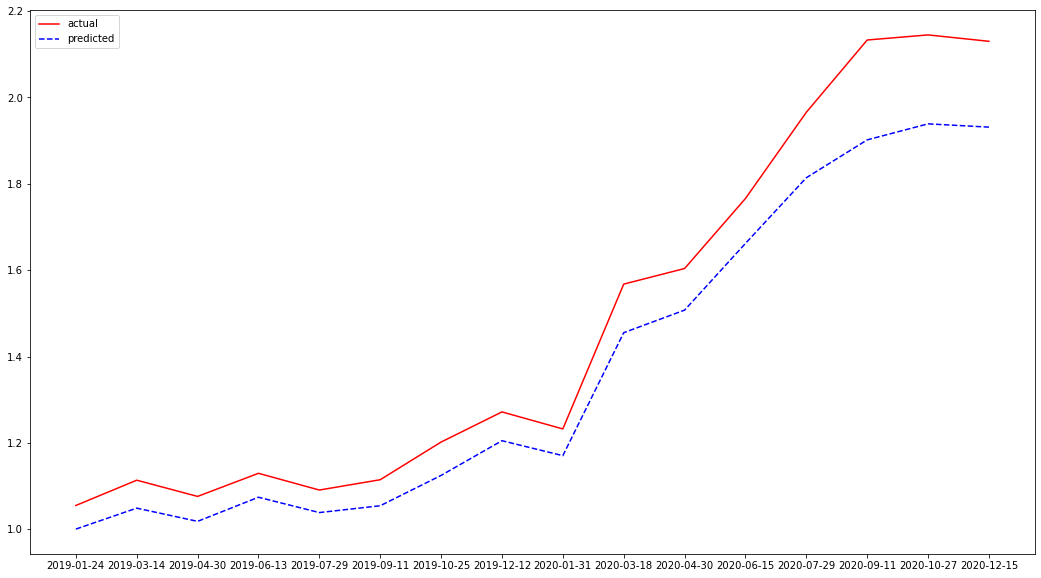

In [35]:
#Use the following code to produce the comparison of actual vs. predicted LinearRegression
fig = plt.gcf()
fig.set_size_inches(18, 10)

# plotting the actual data versus predicted data
predicted_tuned.index = Y_test.index
plt.plot(np.exp(Y_test[::30]).cumprod(), 'r', label='actual')

#. plotting t, a separately
plt.plot(np.exp(lr_tuned[::30]).cumprod(), 'b--', label='predicted')
plt.legend()
plt.show()

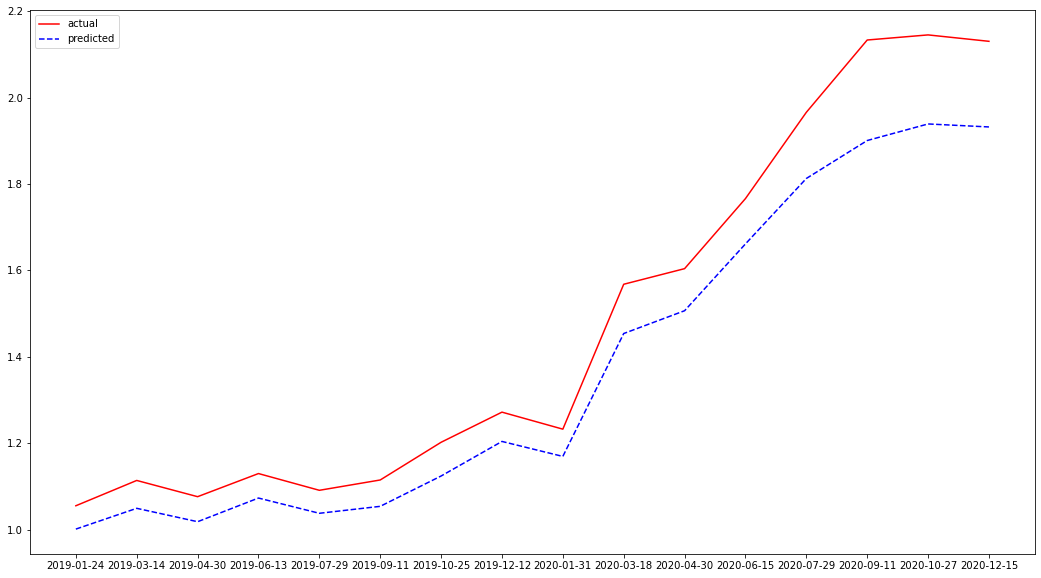

In [21]:
#Use the following code to produce the comparison of actual vs. predicted ARIMA
fig = plt.gcf()
fig.set_size_inches(18, 10)

# plotting the actual data versus predicted data
predicted_tuned.index = Y_test.index
plt.plot(np.exp(Y_test[::30]).cumprod(), 'r', label='actual')

#. plotting t, a separately
plt.plot(np.exp(predicted_tuned[::30]).cumprod(), 'b--', label='predicted')
plt.legend()
plt.show()

We can conclude that simple models - linear regression - along with the time series model such as ARIMA are promising modelling approaches for asset price prediction problem. 

These models can enable financial practitioners to model time dependencies with a very flexible approach. 

The overall approach presented in this case study may help us encounter overfitting and underfitting which are some of the key challenges in the prediction problem in finance. 

We should also note that we can use better set of indicators, such as P/E ratio, trading volume, technical indicators or news data, which might lead to better results. 

Overall, we created a supervised-regression and time series modelling framework which allows us to perform asset class prediction using historical data to generate results and analyze risk and profitability before risking any actual capital.